## Orientation feature tracking hybrid - evaluation
We do limbus detection using Hough transform, where we obtain translation and scale. We manually pick the zeroth degree in initial frame. Then features are detected and rotation is estimated relative to the first frame.

### 1. Imports

In [1]:
import cv2
import numpy as np
import copy
from matplotlib import pyplot as plt
from helpers.limbus_detection import detect_circle
from helpers.orientation_detection_hybrid import estimate_orientation_hybrid, transform_2d_matmul, get_transform_info

%load_ext autoreload
%autoreload 2

### 2. Evaluation on images

In [2]:
MAX_DIM_DEFAULT = 640
LIMBUS_RADIUS_INFLATION = 1.2

In [3]:
def evaluate_images(images, limbus_circles):
    images_count = len(images)
    
    images_values = [cv2.cvtColor(i, cv2.COLOR_BGR2HSV)[:,:,2] for i in images]
    images_vis = [cv2.cvtColor(i, cv2.COLOR_GRAY2BGR) for i in images_values]
    
    # masking
    for i in range(images_count):
        limbus_circle = limbus_circles[i]
        mask = np.zeros((images_values[i].shape[0], images_values[i].shape[1]))
        mask = cv2.circle(mask, (round(limbus_circle[0]), round(limbus_circle[1])), round(
                limbus_circle[2]*LIMBUS_RADIUS_INFLATION), 255, thickness=-1, lineType=cv2.LINE_AA)

        images_values[i][mask == 0] = 0
    
    # orientation detection
    sift = cv2.SIFT_create(contrastThreshold=0.01)
    images_keypoints = []
    images_descriptors = []
    rotations = []
    transform_rotations = []
    transform_no_rotations = []
    goods = []
    
    for i in range(images_count):
        # keypoints, descriptors
        keypoints, descriptors = sift.detectAndCompute(images_values[i], None)
        images_keypoints.append(keypoints)
        images_descriptors.append(descriptors)
        
    for i in range(images_count):
        # rotation, transform_rotation, transform_no_rotation
        rotation, transform_rotation, transform_no_rotation = estimate_orientation_hybrid(
            images_keypoints[0], images_descriptors[0], limbus_circles[0],
            images_keypoints[i], images_descriptors[i], limbus_circles[i],
            verbose=True
        )
        rotations.append(rotation)
        transform_rotations.append(transform_rotation)
        transform_no_rotations.append(transform_no_rotation)
        
        # good
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(images_descriptors[0], images_descriptors[i], k=2)

        # ratio test
        good = []
        for m, n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])
                
        goods.append(good)
    
    # visualization
    fig, plots = plt.subplots(5, images_count, figsize=(10,10*3))
    
    # limbus detections
    for i in range(images_count):
        vis = images_vis[i].copy()
        limbus_circle = limbus_circles[i]
        cv2.circle(vis, (round(limbus_circle[0]), round(limbus_circle[1])), round(
            limbus_circle[2]), (0, 255, 0), thickness=3, lineType=cv2.LINE_AA)
        
        plots[0][i].set_title(f'limbus detection ({i})')
        plots[0][i].imshow(vis)
        plots[0][i].axis('off')
        
    # matches
    for i in range(images_count):
        vis = cv2.drawMatchesKnn(
            images_values[0], images_keypoints[0], 
            images_values[i], images_keypoints[i], 
            goods[i], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        plots[1][i].set_title(f'matches (0x{i})')
        plots[1][i].imshow(vis)
        plots[1][i].axis('off')
        
    # warp & diff
    for i in range(images_count):
        get_transform_info(transform_rotations[i], verbose=True)
        vis = cv2.warpAffine(
            images_vis[0],
            transform_2d_matmul(transform_rotations[i], transform_no_rotations[i]),
            (images_vis[i].shape[1], images_vis[i].shape[0]))
        
        plots[2][i].set_title(f'warp (0->{i})')
        plots[2][i].imshow(vis)
        plots[2][i].axis('off')
        
        diff = cv2.normalize(images_vis[i] - vis, None,
                     alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        
        plots[3][i].set_title(f'diff (0->{i})')
        plots[3][i].imshow(diff)
        plots[3][i].axis('off')
        
    # axis
    for i in range(images_count):
        vis = images_vis[i].copy()
        rad = np.pi * rotations[i] / 180
        start = (
            round(limbus_circles[i][0] + limbus_circles[i][2]*np.cos(rad)),
            round(limbus_circles[i][1] + limbus_circles[i][2]*np.sin(rad)),
        )
        end = (
            round(limbus_circles[i][0] - limbus_circles[i][2]*np.cos(rad)),
            round(limbus_circles[i][1] - limbus_circles[i][2]*np.sin(rad)),
        )
        cv2.line(vis, start, end, (0,255,0), thickness=3, lineType=cv2.LINE_AA)
        
        plots[4][i].set_title(f'axis ({i})')
        plots[4][i].imshow(vis)
        plots[4][i].axis('off')
        
    fig.tight_layout()      
    plt.show()

#### 2.1 Rhexis augmented

translation (px): [0. 0.], rotation angle (deg): 0.0, scale: 1.0
translation (px): [257.93615022 -37.60711024], rotation angle (deg): 41.273298319934035, scale: 1.0016786600425263
translation (px): [527.73218961 157.04177549], rotation angle (deg): 94.90836471758338, scale: 1.0061589928747203


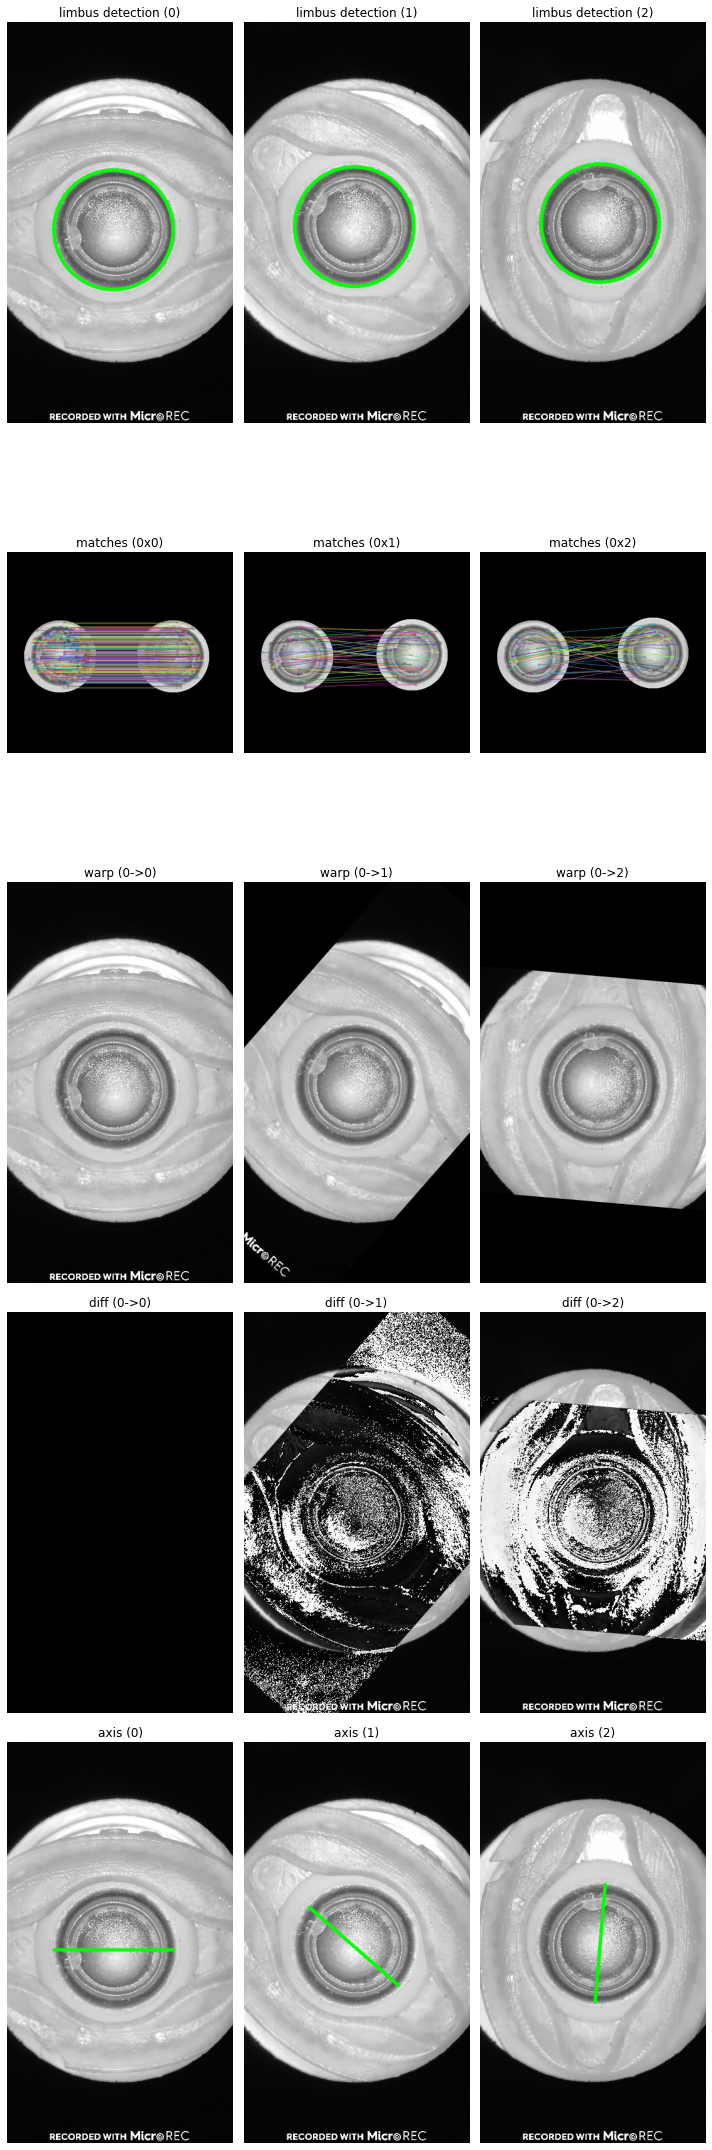

In [4]:
# loading and preprocessing
images_paths = [
    'data/artificial/rhexis_augmented_rotation1.jpg',
    'data/artificial/rhexis_augmented_rotation2.jpg',
    'data/artificial/rhexis_augmented_rotation3.jpg'
]
images = [
    cv2.imread(path)
    for path in images_paths
]

for i in range(len(images)):
    scale = MAX_DIM_DEFAULT / max(images[i].shape)
    images[i] = cv2.resize(images[i], (0,0), fx=scale, fy=scale)

limbus_circles = []
for i in range(len(images)):
    limbus_circle = detect_circle(
        cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)[:,:,2],
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=1.0,
        circle_width_to_radius_ratio=0.1,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=240,
        gaussian_blur_sigma=3.0
    )
    limbus_circles.append(limbus_circle)
    
    


evaluate_images(images, limbus_circles)

#### 2.2 Bioniko

translation (px): [0. 0.], rotation angle (deg): 0.0, scale: 1.0
translation (px): [-140.6387935   110.11717657], rotation angle (deg): -27.81509491061953, scale: 1.0272677802193404
translation (px): [-197.7806101   246.34419741], rotation angle (deg): -49.397121584431936, scale: 1.010604711359232
translation (px): [-175.83463879  462.46616556], rotation angle (deg): -83.53339520483978, scale: 1.0311010640139062
translation (px): [-48.38413704 578.55645151], rotation angle (deg): -113.15307788849681, scale: 0.9494639836265872


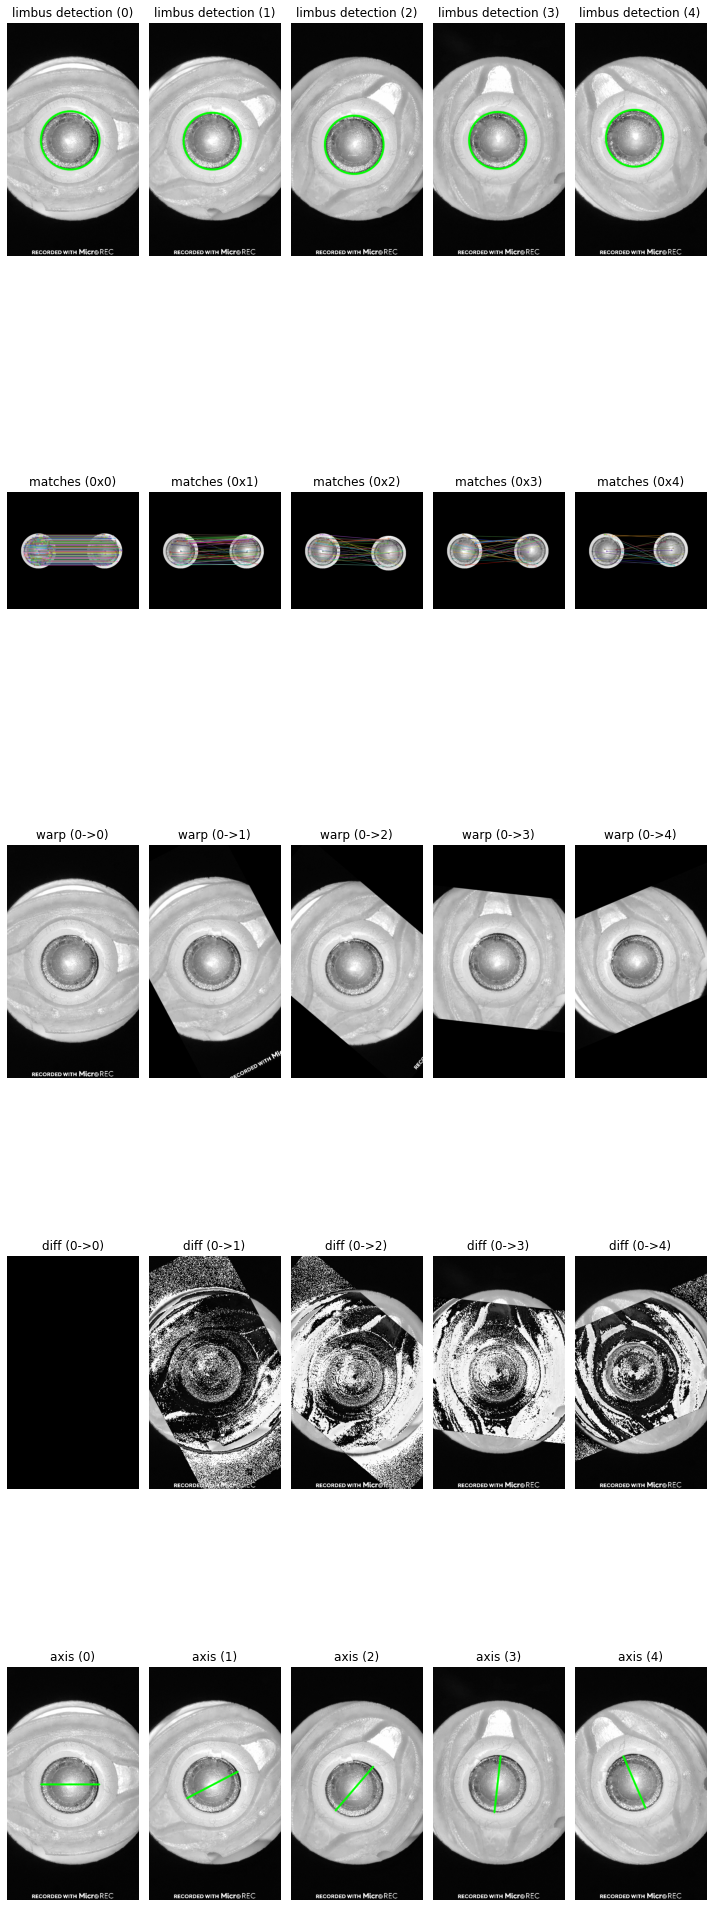

In [5]:
# loading and preprocessing
images_paths = [
    'data/artificial/bioniko_rotation1.jpg',
    'data/artificial/bioniko_rotation2.jpg',
    'data/artificial/bioniko_rotation3.jpg',
    'data/artificial/bioniko_rotation4.jpg',
    'data/artificial/bioniko_rotation5.jpg',
]
images = [
    cv2.imread(path)
    for path in images_paths
]

for i in range(len(images)):
    scale = MAX_DIM_DEFAULT / max(images[i].shape)
    images[i] = cv2.resize(images[i], (0,0), fx=scale, fy=scale)

limbus_circles = []
for i in range(len(images)):
    limbus_circle = detect_circle(
        cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)[:,:,2],
        validation='inout',
        validation_mode='max',
    )
    limbus_circles.append(limbus_circle)

evaluate_images(images, limbus_circles)

#### 2.3 Bioniko augmented

translation (px): [0. 0.], rotation angle (deg): 0.0, scale: 1.0
translation (px): [-146.69533064  142.23194844], rotation angle (deg): -33.894277499883586, scale: 0.9910731605385221
translation (px): [-199.93579992  294.64476174], rotation angle (deg): -59.66394877400729, scale: 0.997484720730042
translation (px): [-152.63356308  475.69936493], rotation angle (deg): -87.62150166391665, scale: 0.9861594269635368


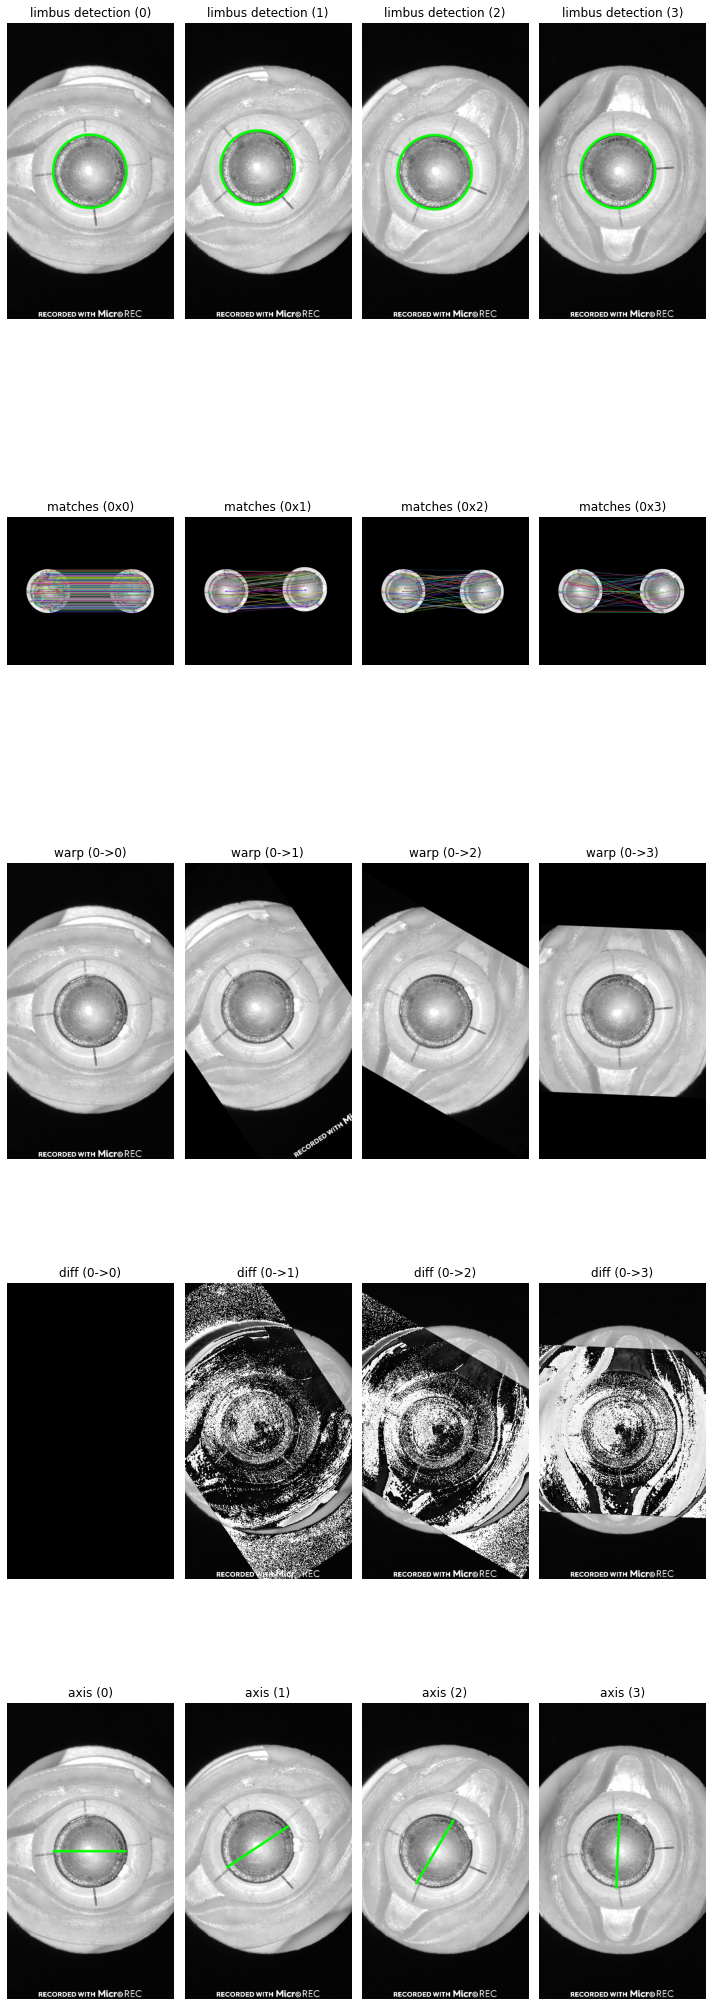

In [6]:
# loading and preprocessing
images_paths = [
    'data/artificial/bioniko_augmented_rotation1.jpg',
    'data/artificial/bioniko_augmented_rotation2.jpg',
    'data/artificial/bioniko_augmented_rotation3.jpg',
    'data/artificial/bioniko_augmented_rotation4.jpg',
]
images = [
    cv2.imread(path)
    for path in images_paths
]

for i in range(len(images)):
    scale = MAX_DIM_DEFAULT / max(images[i].shape)
    images[i] = cv2.resize(images[i], (0,0), fx=scale, fy=scale)

limbus_circles = []
for i in range(len(images)):
    limbus_circle = detect_circle(
        cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)[:,:,2],
        validation='inout',
        validation_mode='max',
    )
    limbus_circles.append(limbus_circle)

evaluate_images(images, limbus_circles)

### 2. Evaluation on videos